# Rocket Car

The Rocket Car problem is a standard problem definition for Optimal Control with ODE Study.
The solution is a well known framework to compare analytics and numerical solutions.
The basic problem defines a Rocket Car that has to move from a point $A$ to a point $B$ and stop there.
To achieve this a control $u(t)$ is used in a manner where when $u(t)>0$ there's an acceleration system, and
when $u(t)<0$ there's a breaking system shooting in.

For an addition of realism, a parameter of max_velocity can be defined, which changes the
behavior of the system.

Letting $\phi(t)$ be the objective function to minimize, there exist basically 3 common definitions:
* Time, $\int_{0}^{T} 1 dt = T$
* Energy, $\int_{0}^{T} \frac{1}{2} u(t)^2 dt$
* Time and Energy combination, $\int_{0}^{T} 1 dt + \int_{0}^{T} \frac{1}{2} u(t)^2 dt$

# Problem Definition

\begin{equation}
\begin{array}{rrclcl}
\displaystyle \min_{u} & \phi(t)\\
\textrm{s.t.}
&{\dot s = v}\\
&{\dot v = u} \\
&{s(0) = 0}    \\
&{v(0) = 0}    \\
&{v(t) \leq v_max} \\
&{r(T, y(t)) = \begin{bmatrix}
           s(T) -d \\
           v(T) \\
         \end{bmatrix}} &=0   \\
\end{array}
\end{equation}

-----------------

![RocketCar](https://www.researchgate.net/profile/John_Burns6/publication/267218497/figure/fig5/AS:641369194364932@1529925740408/The-Rocket-Car-Control-Problem.png)

In [87]:
# importing required packages.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as env
import pyomo.dae as dae
import plotly.express as px

Following an example for solving energy minimization.

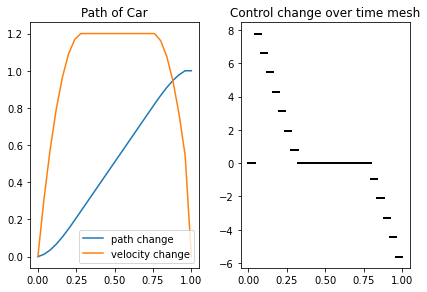

In [88]:
# Initialize general tuning variables
t_f = 1
control = 15
distance = 1
velocity_max = 1.2 # when no max velocity bound is required, set this to np.inf

# Initialize model object
rocket_energy = env.ConcreteModel()

# Initialize time variable
# rocket_energy.tf = env.Var(domain=env.NonNegativeReals)
rocket_energy.t = dae.ContinuousSet(bounds=(0, t_f))

# Define control
rocket_energy.u = env.Var(rocket_energy.t, bounds=(-control, control))


# Define dependent variables
rocket_energy.x = env.Var(rocket_energy.t)
rocket_energy.v = env.Var(rocket_energy.t, bounds=(0, velocity_max))

# Define derivatives
rocket_energy.x_dot = dae.DerivativeVar(rocket_energy.x)
rocket_energy.v_dot = dae.DerivativeVar(rocket_energy.v)

# Define ODE constraints
rocket_energy.ode_x = env.Constraint(rocket_energy.t, rule=lambda m, t: m.x_dot[t] == m.v[t])
rocket_energy.ode_v = env.Constraint(rocket_energy.t, rule=lambda m, t: m.v_dot[t] == m.u[t])

# Set initial and final conditions
rocket_energy.bounds = env.ConstraintList()
rocket_energy.bounds.add(rocket_energy.x[0] == 0)
rocket_energy.bounds.add(rocket_energy.v[0] == 0)
rocket_energy.bounds.add(rocket_energy.x[t_f] == distance)
rocket_energy.bounds.add(rocket_energy.v[t_f] == 0)

# Define model objective
rocket_energy.Integral = dae.Integral(rocket_energy.t, wrt=rocket_energy.t, rule=lambda m, t: 0.5*(m.u[t]**2))
rocket_energy.objective = env.Objective(expr=rocket_energy.Integral)

# %% Solve system
env.TransformationFactory('dae.finite_difference').apply_to(rocket_energy, wrt=rocket_energy.t, nfe=25)
env.SolverFactory('ipopt').solve(rocket_energy)

# %% Plotting results
time = np.array([t for t in rocket_energy.t])
x = np.array([rocket_energy.x[t]() for t in rocket_energy.t])
v = np.array([rocket_energy.v[t]() for t in rocket_energy.t])
u = np.array([rocket_energy.u[t]() for t in rocket_energy.t])
text_display = np.array([str(round(rocket_energy.u[t](), 2))+"m/s "+
                         str(round(rocket_energy.u[t](), 2))+"m/s^2"
                         for t in rocket_energy.t])
solution_rocket_energy = pd.DataFrame(data={'time': time,
                                            'position': x,
                                            'y': np.zeros(x.__len__()),
                                            'velocity': v,
                                            'control': u,
                                            'text': text_display})

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()
axes[0].plot(time, x, label="path change")
axes[0].plot(time, v, label="velocity change")
axes[0].set_title("Path of Car")
axes[0].legend()

for i in range(np.size(u)-1):
    u_temp = ([u[i], u[i]])
    x_temp = ([time[i], time[i+1]])
    axes[1].plot(x_temp, u_temp, '-', lw=2, color='k')
axes[1].set_title("Control change over time mesh")
plt.show()

In [89]:
current_title = "Rocket car solution for energy minimization. v_max=" + str(velocity_max)
animation = px.scatter(solution_rocket_energy,
                       x='position',
                       y='y',
                       animation_frame='time',
                       text='text',
                       title=current_title)
animation.add_traces(px.line(solution_rocket_energy, x='position', y='y')
                     .update_traces(marker_color="red").data[0])
animation.show()


Following an example for solving energy minimization.

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.


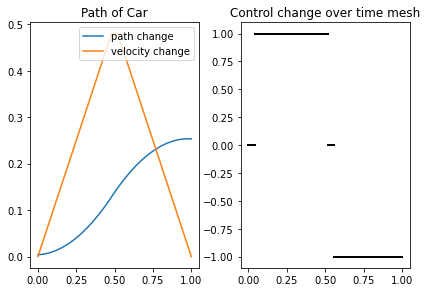

In [94]:
# Initialize general tuning variables
t_f = 1
control = 1
distance = 1
velocity_max = 1.2 # when no max velocity bound is required, set this to np.inf

# Initialize model object
rocket_time = env.ConcreteModel()

# Initialize time variable
rocket_time.t = dae.ContinuousSet(initialize=[1], bounds=(0, np.inf))

# Define control
rocket_time.u = env.Var(rocket_time.t, bounds=(-control, control))


# Define dependent variables
rocket_time.x = env.Var(rocket_time.t)
rocket_time.v = env.Var(rocket_time.t, bounds=(0, velocity_max))

# Define derivatives
rocket_time.x_dot = dae.DerivativeVar(rocket_time.x)
rocket_time.v_dot = dae.DerivativeVar(rocket_time.v)

# Define ODE constraints
rocket_time.ode_x = env.Constraint(rocket_time.t, rule=lambda m, t: m.x_dot[t] == m.v[t])
rocket_time.ode_v = env.Constraint(rocket_time.t, rule=lambda m, t: m.v_dot[t] == m.u[t])

# Set initial and final conditions
rocket_time.bounds = env.ConstraintList()
rocket_time.bounds.add(rocket_time.x[0] == 0)
rocket_time.bounds.add(rocket_time.v[0] == 0)
rocket_time.bounds.add(rocket_time.x[t_f] == distance)
rocket_time.bounds.add(rocket_time.v[t_f] == 0)

# Define model objective
rocket_time.Integral = dae.Integral(rocket_time.t, wrt=rocket_time.t, rule=lambda m, t: 1)
rocket_time.objective = env.Objective(expr=rocket_time.Integral)

# %% Solve system
env.TransformationFactory('dae.finite_difference').apply_to(rocket_time, wrt=rocket_time.t, nfe=25)
env.SolverFactory('ipopt').solve(rocket_time)

# %% Plotting results
time = np.array([t for t in rocket_time.t])
x = np.array([rocket_time.x[t]() for t in rocket_time.t])
v = np.array([rocket_time.v[t]() for t in rocket_time.t])
u = np.array([rocket_time.u[t]() for t in rocket_time.t])
text_display = np.array([str(round(rocket_time.u[t](), 2))+"m/s "+
                         str(round(rocket_time.u[t](), 2))+"m/s^2"
                         for t in rocket_time.t])
solution_rocket_time = pd.DataFrame(data={'time': time,
                                            'position': x,
                                            'y': np.zeros(x.__len__()),
                                            'velocity': v,
                                            'control': u,
                                            'text': text_display})

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()
axes[0].plot(time, x, label="path change")
axes[0].plot(time, v, label="velocity change")
axes[0].set_title("Path of Car")
axes[0].legend()

for i in range(np.size(u)-1):
    u_temp = ([u[i], u[i]])
    x_temp = ([time[i], time[i+1]])
    axes[1].plot(x_temp, u_temp, '-', lw=2, color='k')
axes[1].set_title("Control change over time mesh")
plt.show()

In [ ]:
current_title = "Rocket car solution for time minimization. v_max=" + str(velocity_max)
animation = px.scatter(solution_rocket_time,
                       x='position',
                       y='y',
                       animation_frame='time',
                       text='text',
                       title=current_title)
animation.add_traces(px.line(solution_rocket_time, x='position', y='y')
                     .update_traces(marker_color="red").data[0])